In [34]:
import os
import pandas as pd
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import re


In [35]:

def list_folders_in_path(path):
    """
    Prints all the folders in the given path.

    Args:
        path (str): The directory path to search for folders.
    """
    try:
        # List all directories in the path
        folders = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]
        
        # Print each folder
        # print("Folders in path:", path)
        # for folder in folders:
            # print(folder)
        return folders
    except FileNotFoundError:
        print(f"Error: The path '{path}' does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")

def extract_numbers_from_string(input_string):
    """
    Extracts all numbers from a given string and returns them as a list of integers.

    Args:
        input_string (str): The input string to extract numbers from.

    Returns:
        list: A list of integers extracted from the input string.
    """
    # Find all numbers in the string using a regular expression
    numbers = re.findall(r'\d+', input_string)
    # Convert the numbers to integers
    return list(map(int, numbers))



In [36]:

def evaluate_top_10_percent(csv_path):
    """
    Evaluate MAP, Kendall's Tau, and Spearman Rank Correlation for the top 10% of data in a CSV.
    """
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Sort by Predictions in descending order
    df_sorted = df.sort_values(by='Prediction', ascending=False)

    # Select the top 10% of the data
    top_10_percent = int(len(df_sorted) * 0.1)
    df_top_10 = df_sorted.head(top_10_percent)

    # Compute Mean Average Precision (MAP)
    def compute_map(labels):
        threshold = df['Label'].quantile(0.9)  # Top 10% most influential nodes
        relevance = [1 if label > threshold else 0 for label in labels]  # Binary relevance
        cumsum = 0
        total_relevant = sum(relevance)
        if total_relevant == 0:
            return 0.0  # Avoid division by zero
        for i, rel in enumerate(relevance, start=1):
            if rel:
                cumsum += sum(relevance[:i]) / i
        return cumsum / total_relevant

    # MAP for the top 10%
    map_top_10 = compute_map(df_top_10['Label'])

    # Kendall's Tau and Spearman Rank Correlation
    kendall_tau, _ = kendalltau(df_top_10['Label'], df_top_10['Prediction'])
    spearman_corr, _ = spearmanr(df_top_10['Label'], df_top_10['Prediction'])

    return {
        'MAP': map_top_10,
        "Kendall's Tau": kendall_tau,
        'Spearman Correlation': spearman_corr
    }

def plot_metrics_from_models(folder_path, model_files):
    """
    Plot MAP, Kendall's Tau, and Spearman Correlation for multiple model CSV files.
    """
    results = []
    
    for model_name, csv_file in model_files.items():
        csv_path = os.path.join(folder_path, csv_file)
        metrics = evaluate_top_10_percent(csv_path)
        metrics['Model'] = model_name
        results.append(metrics)

    # Create a DataFrame for results
    results_df = pd.DataFrame(results)

    # Plot the metrics
    metrics = ['MAP', "Kendall's Tau", 'Spearman Correlation']
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 6), constrained_layout=True)

    for ax, metric in zip(axes, metrics):
        ax.bar(results_df['Model'], results_df[metric], color='skyblue', width=0.6)
        ax.set_title(f'{metric} Across Models')
        ax.set_ylabel(metric)
        ax.set_xlabel('Model')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()



In [37]:


# Example usage
path = "./../data"  # Replace with your desired path
models = list_folders_in_path(path)
model_params = [extract_numbers_from_string(g) for g in models] 
for i in range(len(models)):
    print(f'{i}) {model_params[i]} : {models[i]}')

0) [15, 4, 0] : test_L15_b4_sir0
1) [15, 4, 1] : test_L15_b4_sir1
2) [15, 4, 2] : test_L15_b4_sir2
3) [20, 4, 0] : test_L20_b4_sir0
4) [20, 4, 1] : test_L20_b4_sir1
5) [20, 4, 2] : test_L20_b4_sir2
6) [40, 4, 0] : test_L40_b4_sir0
7) [40, 4, 1] : test_L40_b4_sir1
8) [40, 4, 2] : test_L40_b4_sir2
9) [50, 4, 0] : test_L50_b4_sir0
10) [50, 4, 1] : test_L50_b4_sir1
11) [50, 4, 2] : test_L50_b4_sir2
12) [9, 4, 0] : test_L9_b4_sir0
13) [9, 4, 1] : test_L9_b4_sir1
14) [9, 4, 2] : test_L9_b4_sir2


In [39]:

load_dotenv("./model.env")
sir_alpha = int(os.getenv("SIR_ALPHA"))
print('SIR_ALPHA: ', sir_alpha)
_model_L  = int(os.getenv("_MODEL_L"))
print('_MODEL_L: ', _model_L)
num_epochs = int(os.getenv("NUM_EPOCH"))
print('NUM_EPOCH: ', num_epochs)

save_folder = f'test_L{_model_L}_b4_sir{sir_alpha}'
# Example usage
csv_path = f'./../data/{save_folder}/ba_edgelist_exp1_5000_4_df.csv' 
results = evaluate_top_10_percent(csv_path)

SIR_ALPHA:  2
_MODEL_L:  15
NUM_EPOCH:  150


In [ ]:
for i in range(len(models)):
    print(f'{i}) {model_params[i]} : {models[i]}')
    _model_L = model_params[i][0]
    sir_alpha = model_params[i][2]
    save_folder = f'test_L{_model_L}_b4_sir{sir_alpha}'
    csv_path = f'./../data/{save_folder}/ba_edgelist_exp1_5000_4_df.csv'  

# Usage example
folder_path = f'./../data/{save_folder}'  # Replace with the actual folder path
model_files = {
    'Model A': 'ba_edgelist_exp1_4000_4_df.csv',
    'Model B': 'ba_edgelist_exp1_5000_10_df.csv',
    'Model C': 'ba_edgelist_exp1_6000_4_df.csv',
}  # Replace with actual file names

plot_metrics_from_models(folder_path, model_files)
# parameters
sir_alpha = int(os.getenv("SIR_ALPHA"))
print('SIR_ALPHA: ', sir_alpha)
_model_L  = int(os.getenv("_MODEL_L"))
print('_MODEL_L: ', _model_L)
num_epochs = int(os.getenv("NUM_EPOCH"))
print('NUM_EPOCH: ', num_epochs)


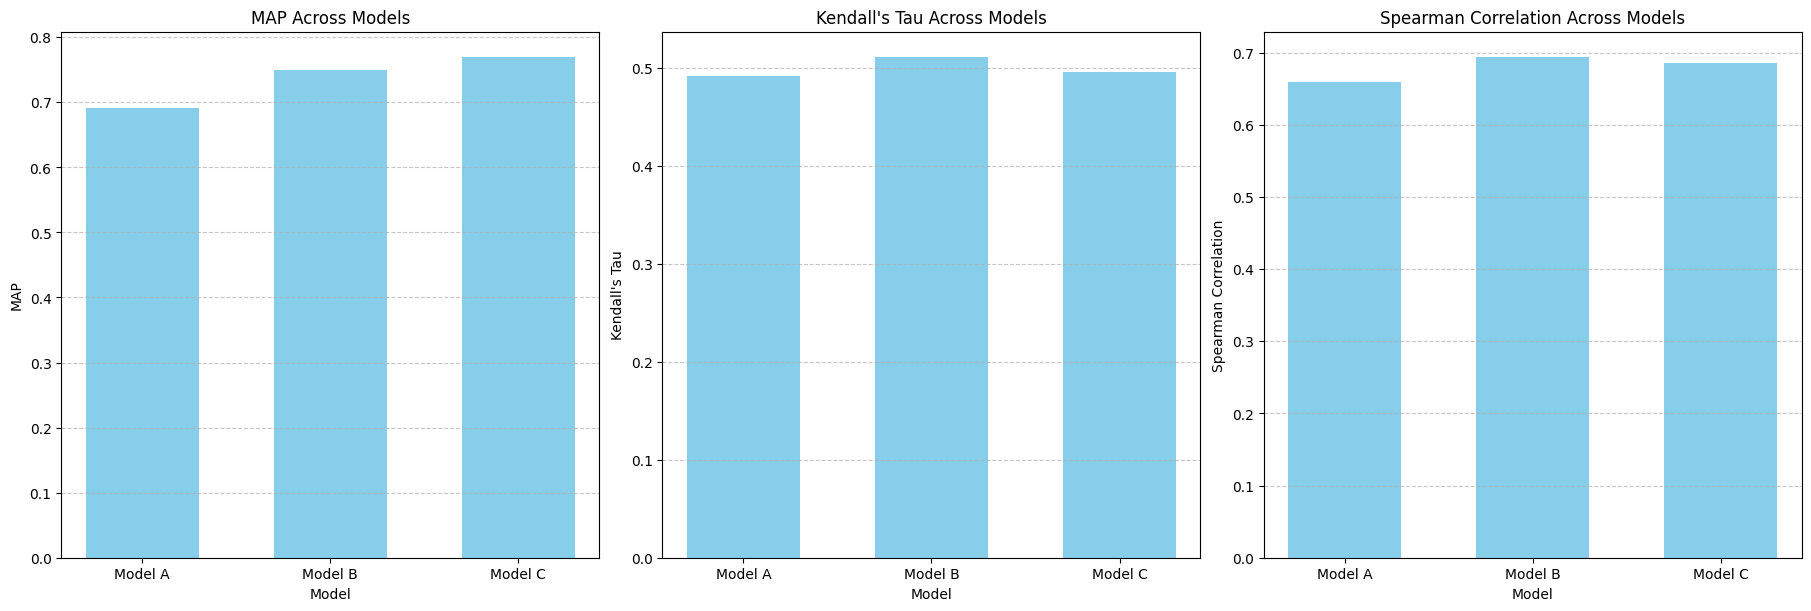

In [42]:

# Usage example
folder_path = f'./../data/{save_folder}'  # Replace with the actual folder path
model_files = {
    'Model A': 'ba_edgelist_exp1_4000_4_df.csv',
    'Model B': 'ba_edgelist_exp1_5000_4_df.csv',
    'Model C': 'ba_edgelist_exp1_6000_4_df.csv',
}  # Replace with actual file names

plot_metrics_from_models(folder_path, model_files)